Для базового прогноза после эксперементов с RandomForestRegressor, решил применить модель CatBoostRegressor, которая известна тем, что хорошо обрабатывает категориальные признаки. Произвел незначительную преднастройку параметров модели (learning_rate=0.01, iterations=800,depth=6) в которую передавались все категориальные признаки без предварительного преобразования. В результате были получены следующие метрики базовой модели : 'learn': {'MAE': 0.5484211616191141, 'R2': 0.4775007535913468, 'RMSE': 0.8864043792332182}, 'validation': {'MAE': 0.6575291727183962, 'R2': 0.146181095969399, 'RMSE': 1.160478590208751}.  

В усовершенствованном методе (5 урок) решил также остановить свой выбор на CatBoostRegressor, использовать крос-валидацию для оценки производительности модели и провеcти оптимизацию гиперпараметров с помощью GridSearchCV. Потому, что гиперпараметры базовой модели и примененный подход к кодированию признаков позволил  улучшить качество модели на тесте по метрикам (MAE = 63973, R2  = 0.48, RMSE = 84822)
Также преобразовал категориальные переменные, часть с помощью one_hot_encoding, а навыки  - TfidfVectorizer. Эксперементировал с методами сокращения размерности матриц, использовал методы PCA и UMAP и менял их размерность от 100 до 500. Качество метрик менялось только в 3 порядке после запятой. Так же переписывал метод TfidfVectorizer, так что бы слова которые часто повторялись имели больший вес, т.е. все сделал наоборот от существующего метода, предполагал, что так как Python часто указывается в вакансиях, то и прирост в ЗП он должен давать больше неже ли упоминание, например, про airFlow. Результат ухудшился по метрикам (R2=0.32, МАЕ = 97000 ). Изменял количество n_gram от 1 до максимального количества скилов в одной вакансии, заметил разницу в том, что метрики сильно не улучшились, но порядок выбираемых скиллов стал сильнее влиять на предсказание ЗП, поэтому отказался от большого количества n_gram и остановился на значении - 1,2.
Произвел обогощение датасета новыми данными (средняя зп по регионам за год и дополнительно добавил принадлежность регионов к федеральным округам).  
При анализе корреляции признаков на тергет, выявил, что сильнее всего оказывают влияние признаки связанные со средней зп по регионам.  
Проводил нормализацию количественных признаков, которые были сгенерированы в комбинации со средней зп по регионам за год.  
Также пробывал нормализовывать значения в разряженной матрице после сжатия методом UMAP. Значительных улучшений не было, иногда ухудшались метрики,но менялись значения 3 порядка после запятой, я не считал что это качественный прирост.


Таким образом оптимальная ошибка была около 63 900 р. (при параметрах learning_rate=0.01, iterations=800,depth=6), что кажется не допустимо для прогноза ЗП в месяц. Улучшение предполагаю возможно достигнуть за счет увеличения датасета и кластеризации названий вакансий.

Так же были учтены Ваши замечания по предыдущей итерации задания, а именно: изменена логика применения fit_transform и transform соответсвенно к обучающей выборке и тестовой; изменена логика пересчета метрик после логарифмирования таргетной переменной

In [3]:
# измененный метод TfidfVectorizer, где вес у слова больше, чем чаще встречается,
# то есть кастомный метод работает наоборот от обычного метода TfidfVectorizer
class CustomTfidfVectorizer(TfidfVectorizer):
    def fit_transform(self, raw_documents, y=None):
        # Вызываем родительский метод для получения стандартной TF-IDF матрицы
        tfidf_matrix = super().fit_transform(raw_documents, y)
        
        # Получаем частоты слов
        word_counts = np.array(self.transform(raw_documents).sum(axis=0)).flatten()
        
        # Изменяем IDF, чтобы часто встречающиеся слова имели больший вес
        idf_adjusted = np.log(1 + (len(raw_documents) / (1 + word_counts)))
        
        # Применяем изменения к TF-IDF матрице
        tfidf_matrix = tfidf_matrix.multiply(idf_adjusted)
        
        return tfidf_matrix

Ниже представлен исправленный код, согласно Вашим замечаниям

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import umap

from catboost import CatBoostRegressor, Pool, cv

import matplotlib.pyplot as plt
import seaborn as sns

Объединяю ранее подготовленные датасеты с телеграмма, и с сайта трудвсем за 2024 г. Необходимо отметить, что данных недостаточно, поэтому прогнозирую, что какие-то специфические навыки могут не оказывать должного влияния на прогнозирование заработной платы в зависимости от скиллов

In [2]:
df_tg = pd.read_csv(r"./dataset_tg.csv", sep ="|")
df_tg.head()

,name_job,type_busy,qualification,location,federalDistrictCode,skills,salary_min,salary_max
0,системный аналитик,remote,middle,Not_location,Not_cod,"Java,Scala,JMS,kafka,Python,REST,UX,UML,UI,JSO...",160000.0,0.0
1,data scientist,remote,middle,Not_location,Not_cod,"Computer Vision,ML",150000.0,230000.0
2,data analyst,full-time,middle,Not_location,Not_cod,"Invite IT,KION,Well,being,DS,Premium,SQL,CLV,B...",240000.0,270000.0
3,системный аналитик,full-time,middle,Краснодарский край,3.0,"net,SQL,Oracle,PosgreSQL",150000.0,200000.0
4,data engineer,full-time,middle,Москва,1.0,"ETL,Impala,ODBC,API,Docker,pandas,GitLab,Redis...",250000.0,0.0


In [3]:
df_trud = pd.read_csv(r"./dataset_trudvsem.csv", sep ="|")
df_trud.head()

,name_job,type_busy,qualification,location,federalDistrictCode,skills,salary_min,salary_max
0,разработчик с,full-time,middle,Курганская область,5.0,NaN,150000.0,0.0
1,разработчик с,full-time,Not_qualification,Свердловская область,5.0,"http,web",180000.0,0.0
2,системный аналитик,full-time,Not_qualification,Пермский край,4.0,NaN,60000.0,0.0
3,маркетолог,full-time,Not_qualification,Приморский край,7.0,BTL,60000.0,60000.0
4,маркетолог,full-time,Not_qualification,Алтайский край,6.0,NaN,70000.0,120000.0


In [4]:
df_ =  pd.concat([df_tg, df_trud], ignore_index=True)
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name_job             1628 non-null   object 
 1   type_busy            1628 non-null   object 
 2   qualification        1628 non-null   object 
 3   location             1613 non-null   object 
 4   federalDistrictCode  1628 non-null   object 
 5   skills               920 non-null    object 
 6   salary_min           1628 non-null   float64
 7   salary_max           1619 non-null   float64
dtypes: float64(2), object(6)
memory usage: 101.9+ KB


Необходимо обратить внимание на большое количество отсутсвующих строк со скилами, столбец с федеральным кодом превышает количество уникальных значений (оказалось, что коды были в строках и числах, затем они приведены к единому типу данных и уникальных стало меньше)

In [5]:
df_.describe(include = object)

,name_job,type_busy,qualification,location,federalDistrictCode,skills
count,1628,1628,1628,1613,1628,920
unique,555,5,4,79,16,765
top,аналитик,full-time,Not_qualification,Москва,Not_cod,"Tableau,BI,Power BI"
freq,110,1276,1094,384,343,24


In [6]:
df_.type_busy.value_counts()

type_busy
full-time     1276
remote         266
part-time       44
temporary       30
internship      12
Name: count, dtype: int64

In [7]:
df_.qualification.value_counts()

qualification
Not_qualification    1094
middle                263
senior                183
junior                 88
Name: count, dtype: int64

В колонке federalDistrictCode неоходимо все значения привести к одному типу, тогда количество категориальных переменных уменьшится

In [8]:
df_.federalDistrictCode = df_.federalDistrictCode.apply(lambda x: str(x))
df_.federalDistrictCode.unique()

array(['Not_cod', '3.0', '1.0', '2.0', '5.0', '4.0', '6.0', '7.0', '8.0'],
      dtype=object)

словарь сопоставления региона вакансии с федеральным кодом

In [9]:
fed_cod = {'Ульяновская область': '4.0',
 'Новосибирская область': '6.0',
 'Тамбовская область': '1.0',
 'Приморский край': '7.0',
 'Пермский край': '4.0',
 'Республика Башкортостан': '4.0',
 'Московская область': '1.0',
 'Республика Бурятия': '7.0',
 'Челябинская область': '5.0',
 'Свердловская область': '5.0',
 'Сахалинская область': '7.0',
 'Саратовская область': '4.0',
 'Удмуртская Республика': '4.0',
 'Смоленская область': '1.0',
 'Иркутская область': '6.0',
 'Москва': '1.0',
 'Красноярский край': '6.0',
 'Пензенская область': '4.0',
 'Краснодарский край': '3.0',
 'Санкт-Петербург': '2.0',
 'Ярославская область': '1.0',
 'Республика Карелия': '2.0',
 'Кемеровская область - Кузбасс': '6.0',
 'Самарская область': '4.0',
 'Курганская область': '5.0',
 'Астраханская область': '3.0',
 'Нижегородская область': '4.0',
 'Ставропольский край': '8.0',
 'Амурская область': '7.0',
 'Республика Дагестан': '8.0',
 'Ростовская область': '3.0',
 'Тверская область': '1.0',
 'Чувашская Республика - Чувашия': '4.0',
 'Чукотский автономный округ': '7.0',
 'Архангельская область': '2.0',
 'Орловская область': '1.0',
 'Ивановская область': '1.0',
 'Алтайский край': '6.0',
 'Омская область': '6.0',
 'Брянская область': '1.0',
 'Костромская область': '1.0',
 'Забайкальский край': '7.0',
 'Республика Татарстан (Татарстан)': '4.0',
 'Ленинградская область': '2.0',
 'Воронежская область': '1.0',
 'Вологодская область': '2.0',
 'Кировская область': '4.0',
 'Рязанская область': '1.0',
 'Республика Крым': '3.0',
 'Республика Северная Осетия - Алания': '8.0',
 'Ханты-Мансийский автономный округ - Югра': '5.0',
 'Волгоградская область': '3.0',
 'Белгородская область': '1.0',
 'Владимирская область': '1.0',
 'Луганская Народная Республика': '3.0',
 'Республика Марий Эл': '4.0',
 'Оренбургская область': '4.0',
 'Тульская область': '1.0',
 'Ямало-Ненецкий автономный округ': '5.0',
 'Курская область': '1.0',
 'Липецкая область': '1.0',
 'Республика Саха (Якутия)': '7.0',
 'Хабаровский край': '7.0',
 'Донецкая Народная Республика': '3.0',
 'Мурманская область': '2.0',
 'Псковская область': '2.0',
 'Тюменская область': '5.0',
 'Республика Хакасия': '6.0',
 'Калининградская область': '2.0',
 'Республика Коми': '2.0',
 'Калужская область': '1.0',
 'Томская область': '6.0',
 'Республика Алтай': '6.0',
 'Республика Адыгея (Адыгея)': '3.0',
 'Чеченская Республика': '8.0',
 'Кабардино-Балкарская Республика': '8.0',
 'Республика Тыва': '6.0',
 'Город Севастополь': '3.0',
 'Ненецкий автономный округ': '2.0',
 'Республика Ингушетия': '8.0',
 'Республика Мордовия': '4.0',
 'Запорожская область': '3.0',
 'Камчатский край': '7.0',
 'Республика Калмыкия': '3.0',
 'Магаданская область': '7.0',
 'Новгородская область': '2.0',
 'Еврейская автономная область': '7.0',
 'Not_location': 'Not_cod',
 'Карачаево-Черкесская Республика': '8.0',
 'Херсонская область': '3.0'}

В клонке с локацией, где присутствуют категориальный признак, убираю отсутсвующие значения, путем замены на новую категорию : "Not_location".

In [10]:
df_["location"].fillna("Not_location", inplace=True)

Проводим оценку колонок с минимальной и максимальной зп. При сборе датасета было допущение, если в вакансии указано одно значение зп, а не вилка, то единственное значение записывалось в колонку с минимальной з/п.

In [11]:
df_.describe(include = float )

,salary_min,salary_max
count,1.628000e+03,1.619000e+03
mean,1.527867e+05,1.092127e+05
std,6.099144e+05,1.662485e+05
min,0.000000e+00,0.000000e+00
25%,3.500000e+04,0.000000e+00
50%,7.550000e+04,3.450000e+04
75%,2.000000e+05,1.750000e+05
max,1.500000e+07,1.500000e+06


В колонке с максимальным уровнем зп заменяю отсутсвующие значения на 0.

In [12]:
df_["salary_max"].fillna(0, inplace=True)

Нулевые значения в колонке с минимальным уровнем з/п заменяю на значение из колонки с максимальным уровнем з/п, и на оборот

In [13]:
df_['salary_min'] = df_[["salary_min","salary_max"]].apply(lambda row: row['salary_max'] if row['salary_min'] ==0 else row['salary_min'],axis=1)
df_['salary_max'] = df_[["salary_min","salary_max"]].apply(lambda row: row['salary_min'] if row['salary_max'] ==0 else row['salary_max'],axis=1)

In [14]:
df_.describe(include = float )

,salary_min,salary_max
count,1.628000e+03,1.628000e+03
mean,1.538347e+05,1.883360e+05
std,6.097319e+05,6.168374e+05
min,1.300000e+01,1.000000e+03
25%,3.660275e+04,4.233200e+04
50%,8.000000e+04,9.590000e+04
75%,2.000000e+05,2.500000e+05
max,1.500000e+07,1.500000e+07


Обогощение данными:  дабавляю статистику по субъектам (средняя з/п)

In [15]:
stat_sal = {'Ульяновская область':110300,
'Новосибирская область':113800,
'Тамбовская область':109500,
'Приморский край':109000,
'Пермский край':110800,
'Республика Башкортостан':110500,
'Московская область':109300,
'Республика Бурятия':108300,
'Челябинская область':110400,
'Свердловская область':111100,
'Сахалинская область':104800,
'Саратовская область':110600,
'Удмуртская Республика':110300,
'Смоленская область':113200,
'Иркутская область':107600,
'Москва':104400,
'Красноярский край':106700,
'Пензенская область':111000,
'Краснодарский край':109000,
'Санкт-Петербург':105200,
'Ярославская область':111500,
'Республика Карелия':108200,
'Кемеровская область - Кузбасс':110400,
'Самарская область':111700,
'Курганская область':115900,
'Астраханская область':106600,
'Нижегородская область':111000,
'Ставропольский край':106000,
'Амурская область':102900,
'Республика Дагестан':105200,
'Ростовская область':109500,
'Тверская область':112000,
'Чувашская Республика - Чувашия':114800,
'Чукотский автономный округ':106800,
'Архангельская область':106200,
'Орловская область':109900,
'Ивановская область':109500,
'Алтайский край':110600,
'Омская область':112200,
'Брянская область':110100,
'Костромская область':108000,
'Забайкальский край':109600,
'Республика Татарстан (Татарстан)':112800,
'Ленинградская область':107200,
'Воронежская область':109300,
'Вологодская область':103700,
'Кировская область':111100,
'Рязанская область':110100,
'Республика Крым':105500,
'Республика Северная Осетия - Алания':106700,
'Ханты-Мансийский автономный округ - Югра':108400,
'Волгоградская область':111200,
'Белгородская область':107800,
'Владимирская область':109900,
'Луганская Народная Республика':103700,
'Республика Марий Эл':112300,
'Оренбургская область':116200,
'Тульская область':111700,
'Ямало-Ненецкий автономный округ':106600,
'Курская область':109400,
'Липецкая область':109400,
'Республика Саха (Якутия)':105700,
'Хабаровский край':109300,
'Донецкая Народная Республика':103700,
'Мурманская область':106000,
'Псковская область':109300,
'Тюменская область':108900,
'Республика Хакасия':108000,
'Калининградская область':108600,
'Республика Коми':106600,
'Калужская область':106900,
'Томская область':110600,
'Республика Алтай':112700,
'Республика Адыгея (Адыгея)':110100,
'Чеченская Республика':105400,
'Кабардино-Балкарская Республика':106500,
'Республика Тыва':104200,
'Город Севастополь':103700,
'Ненецкий автономный округ':104400,
'Республика Ингушетия':101400,
'Республика Мордовия':112000,
'Запорожская область':103700,
'Камчатский край':107500,
'Республика Калмыкия':111300,
'Магаданская область':104400,
'Новгородская область':111000,
'Еврейская автономная область':108300,
'Карачаево-Черкесская Республика':107500,
'Херсонская область':103700,
'Not_location':108900}

df_["salary_stat_mean"] = df_["location"].map(stat_sal)

df_["salary_stat_mean"].isnull().sum()

0

In [16]:
df_.describe()

,salary_min,salary_max,salary_stat_mean
count,1.628000e+03,1.628000e+03,1628.000000
mean,1.538347e+05,1.883360e+05,108022.297297
std,6.097319e+05,6.168374e+05,2825.951016
min,1.300000e+01,1.000000e+03,103700.000000
25%,3.660275e+04,4.233200e+04,104800.000000
50%,8.000000e+04,9.590000e+04,108900.000000
75%,2.000000e+05,2.500000e+05,109900.000000
max,1.500000e+07,1.500000e+07,116200.000000


In [17]:
df_["location"] = df_["location"].apply(lambda x: " ".join([i.strip().lower() for i in x if i.isalpha()]))

In [18]:
df = df_.copy()

Удаляю строки, где нет скилов

In [19]:
df = df[df["skills"].notna()]
df

,name_job,type_busy,qualification,location,federalDistrictCode,skills,salary_min,salary_max,salary_stat_mean
0,системный аналитик,remote,middle,n o t l o c a t i o n,Not_cod,"Java,Scala,JMS,kafka,Python,REST,UX,UML,UI,JSO...",160000.0,160000.0,108900
1,data scientist,remote,middle,n o t l o c a t i o n,Not_cod,"Computer Vision,ML",150000.0,230000.0,108900
2,data analyst,full-time,middle,n o t l o c a t i o n,Not_cod,"Invite IT,KION,Well,being,DS,Premium,SQL,CLV,B...",240000.0,270000.0,108900
3,системный аналитик,full-time,middle,к р а с н о д а р с к и й к р а й,3.0,"net,SQL,Oracle,PosgreSQL",150000.0,200000.0,109000
4,data engineer,full-time,middle,м о с к в а,1.0,"ETL,Impala,ODBC,API,Docker,pandas,GitLab,Redis...",250000.0,250000.0,104400
...,...,...,...,...,...,...,...,...,...
1575,интернет маркетолог,full-time,Not_qualification,и р к у т с к а я о б л а с т ь,6.0,coreldraw,60000.0,60000.0,107600
1599,bim менеджер,full-time,Not_qualification,м о с к в а,1.0,BIM,175000.0,175000.0,104400
1608,маркетолог,remote,Not_qualification,р е с п у б л и к а б у р я т и я,7.0,"SMM,SEO,email",50000.0,90000.0,108300
1613,bim координатор,full-time,Not_qualification,м о с к в а,1.0,"EIR,BIM,BEP",135000.0,135000.0,104400


Добавляю новые признаки по з/п, прогнозировать буду среднее значение зп (возможно, далее в тексте будет местами просто написано зп, но имеется ввиду среднее значение) и также потом при обучении модели возьму логарифм от средней з/п. 
Из-за того, что в категории с квалификацией класс "Not_qualification" преобладает, то генерировать новые признаки комбинируя с уровнем квалификации не имеет смысла, а далее я их кодирую через one_hot_encoding   
Данные по локации также распределены не равномерно, преобладают МСК и СПБ и отсутствуют ряд регионов, поэтому также не использую их для совместной комбинации с другими признаками. Возможно в будущем данный признак ни как не повлияет на значение прогноза средней зп, что косвенно подтверждается отсутвием данного критерия у конкурентов.  
Без пропусков, но не равномерно представлен категориальный признак по типу занятости. Перевод его в ранг и пробывать комбинировать его с другими числовыми признаками нет возможности.

ниже представлены новые признаки на основании средней зп по региону, после деления на тестовые данные и тренеровочные необходимо провести нормализацию их (это новые данные, используемые для обогощения собранного датасета). Думал найти какие-то экономические показатели регионов, так как, возможно, они влияют на привлечение новых технологий и соответственно на уровень зп.

In [20]:
df["salary_mean"] = (df["salary_max"]+df["salary_min"])/2
#отношение
df["salary_stat_mean_1"] = (df["salary_stat_mean"].mean()/df["salary_stat_mean"])
df["salary_stat_mean_2"] = (df["salary_stat_mean"]/df["salary_stat_mean"].max())
df["salary_stat_mean_3"] = (df["salary_stat_mean"]/df["salary_stat_mean"].min())
df["salary_stat_mean_4"] = (df["salary_stat_mean"].median()/df["salary_stat_mean"])

#перемножение, требует нормализации
df["salary_stat_mean_6"] = (df["salary_stat_mean"].mean()*df["salary_stat_mean"])
df["salary_stat_mean_7"] = (df["salary_stat_mean"]*df["salary_stat_mean"].max())
df["salary_stat_mean_8"] = (df["salary_stat_mean"]*df["salary_stat_mean"].min())
df["salary_stat_mean_9"] = (df["salary_stat_mean"].median()*df["salary_stat_mean"])


In [21]:
df.describe()

,salary_min,salary_max,salary_stat_mean,salary_mean,salary_stat_mean_1,salary_stat_mean_2,salary_stat_mean_3,salary_stat_mean_4,salary_stat_mean_6,salary_stat_mean_7,salary_stat_mean_8,salary_stat_mean_9
count,9.200000e+02,9.200000e+02,920.000000,9.200000e+02,920.000000,920.000000,920.000000,920.000000,9.200000e+02,9.200000e+02,9.200000e+02,9.200000e+02
mean,2.312543e+05,2.879686e+05,107343.369565,2.596115e+05,1.000600,0.923781,1.035134,1.015110,1.152260e+10,1.247330e+10,1.113151e+10,1.168969e+10
std,8.019611e+05,8.056435e+05,2637.100238,8.026843e+05,0.024439,0.022694,0.025430,0.024793,2.830752e+08,3.064310e+08,2.734673e+08,2.871802e+08
min,1.300000e+01,1.000000e+03,103700.000000,9.500000e+02,0.923781,0.892427,1.000000,0.937177,1.113151e+10,1.204994e+10,1.075369e+10,1.129293e+10
25%,8.000000e+04,1.100000e+05,104400.000000,1.000000e+05,0.985706,0.898451,1.006750,1.000000,1.120665e+10,1.213128e+10,1.082628e+10,1.136916e+10
50%,1.800000e+05,2.425000e+05,108900.000000,2.000000e+05,0.985706,0.937177,1.050145,1.000000,1.168969e+10,1.265418e+10,1.129293e+10,1.185921e+10
75%,2.500000e+05,3.500000e+05,108900.000000,3.000000e+05,1.028193,0.937177,1.050145,1.043103,1.168969e+10,1.265418e+10,1.129293e+10,1.185921e+10
max,1.500000e+07,1.500000e+07,116200.000000,1.500000e+07,1.035134,1.000000,1.120540,1.050145,1.247330e+10,1.350244e+10,1.204994e+10,1.265418e+10


Удалим по 2,5 % значений, что бы откинуть выбросы

In [22]:
thr_l, thr_r = np.percentile(df.salary_mean, [2.5, 97.5])
df = df[(df.salary_mean > thr_l) & (df.salary_mean < thr_r)]

Посмотрим на распределение категориальных критериев. Распределение классов не равномерное, надо применять подход дублирования вакансий (не стал, думаю что из-за большой разбалансировки и присутсвия неразмеченной категории (not_qualification) это не совсем нужный подход, а если наоборот удалять вакансии для выравнивания классов, то останется катастрофически мало данных)

c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


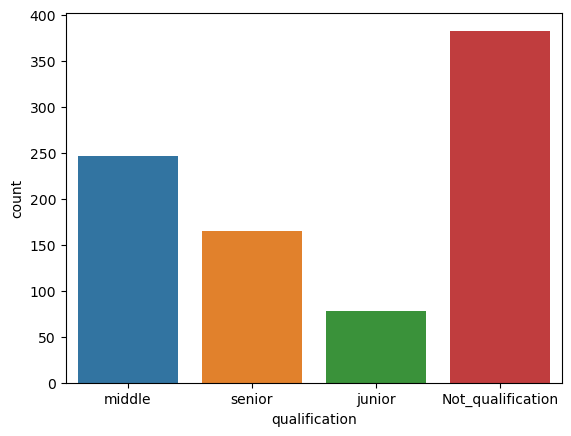

In [23]:
sns.countplot(x ='qualification', data = df)
plt.show()

Тут расбалансировка класов по типу занятости, считаю приемлимой, так как она приблизительно отражает истинную природу предложений, может быть не по колличеству но тенденция предложений вакансий по типу занятости отражается

c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


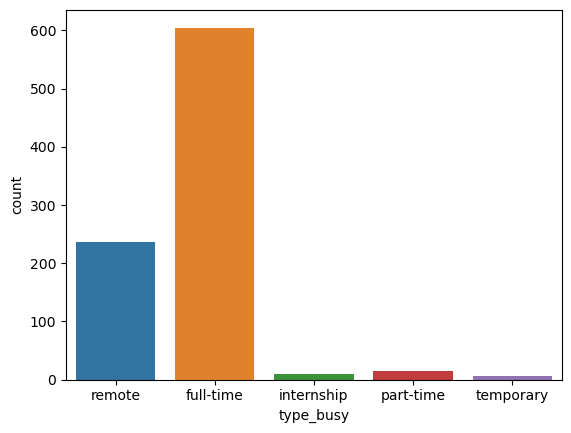

In [24]:
sns.countplot(x ='type_busy', data = df)
plt.show()

Рассмотрим совместное распределение ранее рассмотренных категориальных признаков. Немного недает покоя, кто попал в не размеченную категорию по квалификации (not_qualification), потому что очень большая  по количеству по соотношению к другим.

c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

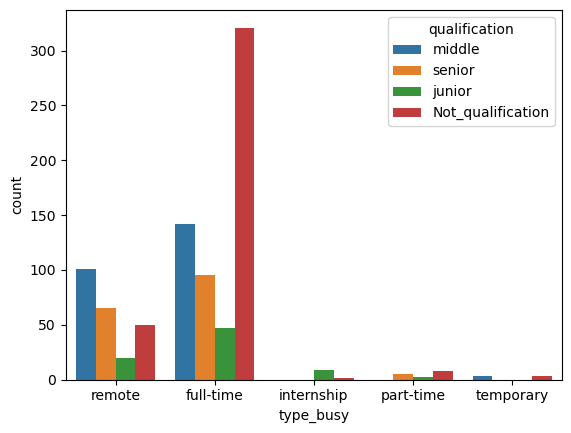

In [25]:
sns.countplot(x ='type_busy', hue = "qualification", data = df)
plt.show()

Посмотрим распределение средней зп по квалификации. И из графика ниже видим, что акансии не размеченные по квалификации скорее всего в большенстве джуны и мидлы. Наблюдается в данных смещение по з/п у джунов и мидлов. Скорее всего будет выдавать для джунов завышенный прогноз по з/п, ну и для некоторых мидлов. Наверное, от части такое смещение наблюдается и из-за того, что в РФ нет задокументированного/формализованного подхода к определению квалификации сотрудников по выполняемым обязанностям в ИТ компаниях, то есть компании самостоятеьно назначают уровнии квалификации

c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='salary_mean', ylabel='qualification'>

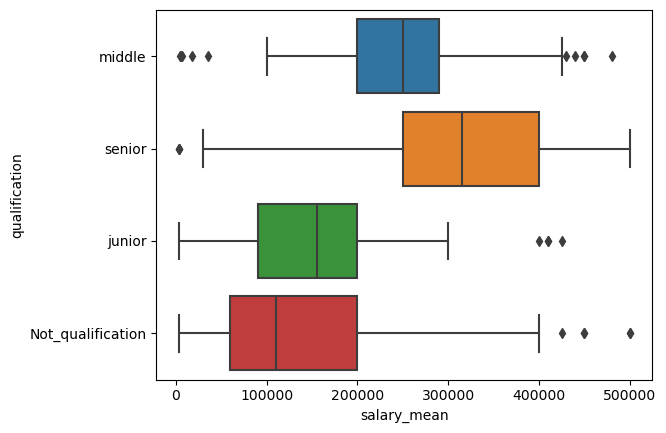

In [26]:
sns.boxplot(data=df, x="salary_mean", y="qualification")

c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='salary_mean', ylabel='type_busy'>

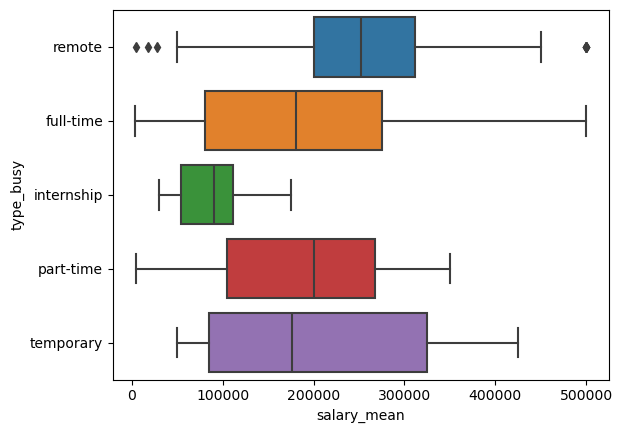

In [27]:
sns.boxplot(data=df, x="salary_mean", y="type_busy")

Посмотрим распределение средней з/п

c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


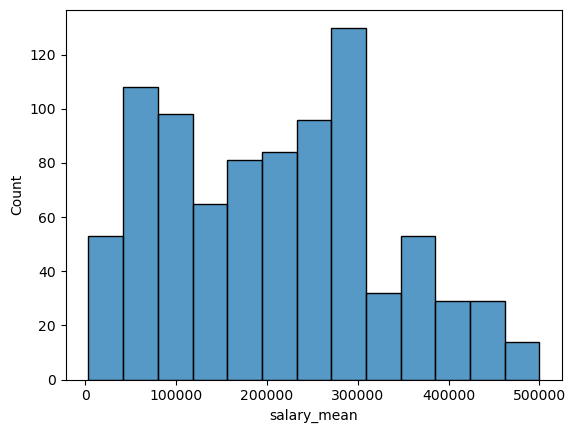

In [28]:
sns.histplot(df["salary_mean"])
plt.show()

Выбросы все еще остаются , но меньше. Думал изначально квантовать на группы з/п и потом классификацию применить, но из-за имеющихся "провалов" данных отказался от идеии. Буду использовать регрессию

c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


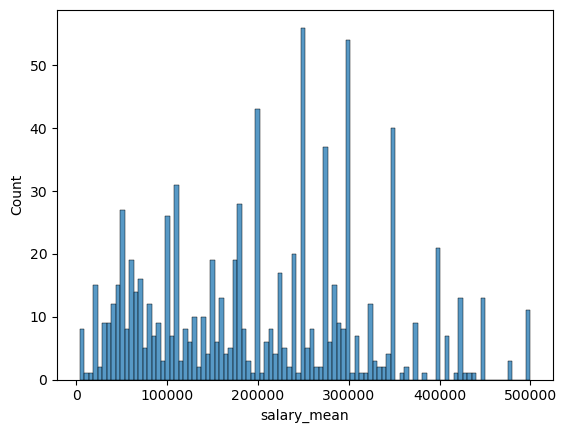

In [29]:
sns.histplot(df["salary_mean"], bins= 100)
plt.show()

Оценим распределение пролагорифмированной средней зп

c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


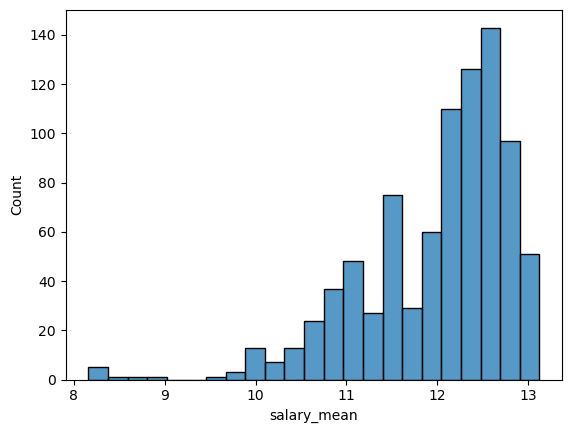

In [30]:
sns.histplot(np.log(df["salary_mean"]))
plt.show()

In [31]:
df.reset_index(drop = True, inplace=True)

Првожу разиение датасета на подвыборки: трейин тест

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="salary_mean"),
                                                    np.log(df["salary_mean"]), 
                                                    train_size=0.8, 
                                                    random_state=42)

In [51]:
y_train_df = y_train.to_csv(r"./y_train.csv", sep ="|", header=True)
y_test_df = y_test.to_csv(r"./y_test.csv", sep ="|", header=True)

Категориaльные переменные [type_busy qualification location federalDistrictCode] закодирую через one_hot_encoding из sklearn. Эксперементировал кодировать локацию через one_hot_encoding и просто в catboost передавать, разницу не заметил на прогнозе зп. Решил отдать эту локацию в катбуст, так как там происходит обработка разреженных матриц

Далее провожу кодирование признаков, уменьшение размерности, нормализацию для подвыборки X_train

In [33]:
#кодируем колонку с типом занятости 
ohe_encoded_type_busy = OneHotEncoder(sparse_output = False)
encoded_type_busy = ohe_encoded_type_busy.fit(X_train[["type_busy"]])
encoded_df_type_busy = pd.DataFrame(encoded_type_busy.transform(X_train[["type_busy"]]),columns = encoded_type_busy.get_feature_names_out(), dtype=int)
#удаляем сами ненужную колонку
encoded_df_type_busy.drop(columns=["type_busy_internship"], inplace=True)

#кодируем колонку с квалификацией
ohe_encoded_qualification = OneHotEncoder(sparse_output = False)
encoded_qualification = ohe_encoded_qualification.fit(X_train[["qualification"]])
encoded_df_qualification = pd.DataFrame(encoded_qualification.transform(X_train[["qualification"]]),columns = encoded_qualification.get_feature_names_out(), dtype=int)
#удаляем сами не нужную колонку
encoded_df_qualification.drop(columns=["qualification_Not_qualification"], inplace=True)

"""
ohe_encoded_location = OneHotEncoder(sparse_output = False)
#кодируем колонку с локацией
encoded_location = ohe_encoded_location.fit(df[["location"]])
encoded_df_location = pd.DataFrame(encoded_location.transform(df[["location"]]),columns = encoded_location.get_feature_names_out(), dtype=int)
#удаляем сами не нужную колонку
encoded_df_location.drop(columns=["location_Not_location"], inplace=True)
"""

#кодируем колонку с federalDistrictCode
ohe_encoded_federalDistrictCode = OneHotEncoder(sparse_output = False)
encoded_federalDistrictCode = ohe_encoded_federalDistrictCode.fit(X_train[["federalDistrictCode"]])
encoded_df_federalDistrictCode = pd.DataFrame(encoded_federalDistrictCode.transform(X_train[["federalDistrictCode"]]),columns = encoded_federalDistrictCode.get_feature_names_out(), dtype=int)
#удаляем сами не нужную колонку
encoded_df_federalDistrictCode.drop(columns=["federalDistrictCode_Not_cod"], inplace=True)

'''
encoded_df = pd.concat([ encoded_df_type_busy, encoded_df_qualification, encoded_df_location, encoded_df_federalDistrictCode],
                   axis=1)
'''
X_train_encoded_df = pd.concat([ encoded_df_type_busy, encoded_df_qualification, encoded_df_federalDistrictCode],
                   axis=1)
X_train_encoded_df.reset_index(drop = True, inplace=True)
X_train_encoded_df

,type_busy_full-time,type_busy_part-time,type_busy_remote,type_busy_temporary,qualification_junior,qualification_middle,qualification_senior,federalDistrictCode_1.0,federalDistrictCode_2.0,federalDistrictCode_3.0,federalDistrictCode_4.0,federalDistrictCode_5.0,federalDistrictCode_6.0,federalDistrictCode_7.0,federalDistrictCode_8.0
0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
693,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
694,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
695,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Обрабатывать skills буду через It-idf c n-grams

In [34]:
tfidf_vectorizer_skills = TfidfVectorizer(ngram_range = (1,2), stop_words = "english")
tfidf_matrix_skills = tfidf_vectorizer_skills.fit_transform(X_train["skills"].str.lower().tolist())
tfidf_matrix_skills_normalized = normalize(tfidf_matrix_skills , norm='l2', axis=1)
Tfidf_df_skills = pd.DataFrame(tfidf_matrix_skills_normalized.toarray(), columns =tfidf_vectorizer_skills.get_feature_names_out())

"""
tfidf_vectorizer_job = TfidfVectorizer(ngram_range = (1,2), stop_words = "english")
tfidf_matrix_job = tfidf_vectorizer_job.fit_transform(df["name_job"].str.lower().tolist())
tfidf_matrix_job_normalized = normalize(tfidf_matrix_job , norm='l2', axis=1)
Tfidf_df_job = pd.DataFrame(tfidf_matrix_job_normalized.toarray(), columns = tfidf_vectorizer_job.get_feature_names_out())
Tfidf_df =pd.concat([ Tfidf_df_job, Tfidf_df_skills], axis=1)
"""

X_train_Tfidf_df =Tfidf_df_skills
X_train_Tfidf_df.reset_index(drop = True, inplace=True)
X_train_Tfidf_df

,10,10 windows,1c,1c bootstrap,1c erp,1c wms,1с,2003,3d,3d revit,...,zion,zion development,zone,zone oracle,zoom,zoom data,zoom mlops,zoom telegram,zorion,zorion appsflyer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Для сжатия матрицы skills использую PCA

In [35]:
pca = PCA(n_components = 150)
X_train_Tfidf_df = pca.fit_transform(X_train_Tfidf_df)
X_train_PCA_dataset = pd.DataFrame(X_train_Tfidf_df, columns=[f'PCA_{i+1}' for i in range(150)])
X_train_PCA_dataset

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_141,PCA_142,PCA_143,PCA_144,PCA_145,PCA_146,PCA_147,PCA_148,PCA_149,PCA_150
0,0.086633,0.024114,0.073980,0.010841,0.012208,0.085417,-0.005350,-0.018639,-0.008932,-0.010646,...,0.073865,0.027927,-0.000854,-0.014551,-0.027473,0.031210,-0.021633,0.023534,-0.010446,0.043563
1,0.261652,0.000440,-0.020031,-0.013415,0.003442,-0.002544,0.002335,-0.000974,0.000224,-0.017953,...,-0.054732,-0.013167,-0.018874,-0.012011,0.029774,-0.046254,0.021524,-0.012325,0.007372,0.037320
2,-0.052076,-0.015756,-0.077060,-0.055088,-0.036861,0.017107,0.058430,0.070072,0.046015,0.010783,...,0.110951,-0.037837,-0.113508,0.061494,0.054525,0.084554,0.034060,0.061323,0.025884,0.046619
3,-0.073756,0.138675,0.106765,-0.003516,0.017850,0.155157,-0.074620,0.091006,-0.029583,-0.022560,...,-0.003943,0.012410,-0.019990,-0.041875,-0.100086,-0.025604,0.033269,-0.035250,-0.001515,-0.006916
4,-0.051271,-0.043088,0.002785,-0.031955,-0.001502,-0.010067,-0.018169,-0.022674,-0.020690,-0.029559,...,-0.047065,0.072481,-0.023938,0.006791,0.015678,0.137543,-0.008069,-0.030152,-0.070677,0.000840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,-0.079936,-0.126416,0.135452,-0.059582,0.035881,0.194659,-0.101026,-0.211446,-0.156440,-0.050889,...,-0.017506,-0.006435,0.000223,0.001447,0.008394,0.008268,0.001099,0.014116,0.009994,-0.019083
693,-0.055835,-0.043001,0.012906,-0.025430,-0.020512,-0.020242,-0.014059,-0.007353,-0.003580,0.004219,...,-0.021925,-0.021432,-0.002460,-0.025934,0.005858,0.002107,-0.054305,0.002199,-0.021723,0.014592
694,-0.047775,-0.008114,0.028982,-0.011563,0.058032,0.126266,-0.020402,0.033195,-0.020965,-0.090215,...,-0.026205,0.044532,-0.009821,-0.014325,0.003542,0.034557,0.193975,0.023291,-0.000145,0.053441
695,-0.057299,-0.025962,-0.073552,-0.055799,-0.024219,0.055145,0.073244,0.079149,0.042385,-0.010828,...,0.024590,-0.007006,-0.008220,-0.044093,0.097684,-0.014454,-0.024255,-0.092671,-0.030942,-0.057019


Провожу нормализацию нагенерированных признаком с участием средней заработной платы для X_train

In [36]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train[['salary_stat_mean', 'salary_stat_mean_1',
                                        'salary_stat_mean_2', 'salary_stat_mean_3', 'salary_stat_mean_4',
                                        'salary_stat_mean_6', 'salary_stat_mean_7',
                                        'salary_stat_mean_8', 'salary_stat_mean_9']])


columns=X_train[['salary_stat_mean', 'salary_stat_mean_1',
                                        'salary_stat_mean_2', 'salary_stat_mean_3', 'salary_stat_mean_4',
                                        'salary_stat_mean_6', 'salary_stat_mean_7',
                                        'salary_stat_mean_8', 'salary_stat_mean_9']].columns
X_train_sal_df = pd.DataFrame(X_train_sc, columns=columns )
X_train_sal_df.reset_index(drop = True, inplace=True)

Собираю dataFrame X_train

In [37]:
df_job_loc = X_train[['name_job', 'location']]
df_job_loc.reset_index(drop = True, inplace=True)

In [38]:
X_train_df_new = pd.concat([df_job_loc, X_train_sal_df, X_train_encoded_df, X_train_PCA_dataset], axis=1)
X_train_df_new.shape

(697, 176)

In [49]:
X_train = X_train_df_new.to_csv(r"./X_train.csv", sep ="|", header=True)


Далее провожу кодирование признаков, уменьшение размерности, нормализацию для подвыборки X_test

In [39]:
#кодируем колонку с типом занятости
encoded_df_type_busy = pd.DataFrame(encoded_type_busy.transform(X_test[["type_busy"]]),columns = encoded_type_busy.get_feature_names_out(), dtype=int)
#удаляем сами ненужную колонку
encoded_df_type_busy.drop(columns=["type_busy_internship"], inplace=True)

#кодируем колонку с квалификацией
encoded_df_qualification = pd.DataFrame(encoded_qualification.transform(X_test[["qualification"]]),columns = encoded_qualification.get_feature_names_out(), dtype=int)
#удаляем сами не нужную колонку
encoded_df_qualification.drop(columns=["qualification_Not_qualification"], inplace=True)

"""
ohe_encoded_location = OneHotEncoder(sparse_output = False)
#кодируем колонку с локацией
encoded_location = ohe_encoded_location.fit(df[["location"]])
encoded_df_location = pd.DataFrame(encoded_location.transform(df[["location"]]),columns = encoded_location.get_feature_names_out(), dtype=int)
#удаляем сами не нужную колонку
encoded_df_location.drop(columns=["location_Not_location"], inplace=True)
"""

#кодируем колонку с federalDistrictCode
encoded_df_federalDistrictCode = pd.DataFrame(encoded_federalDistrictCode.transform(X_test[["federalDistrictCode"]]),columns = encoded_federalDistrictCode.get_feature_names_out(), dtype=int)
#удаляем сами не нужную колонку
encoded_df_federalDistrictCode.drop(columns=["federalDistrictCode_Not_cod"], inplace=True)

'''
encoded_df = pd.concat([ encoded_df_type_busy, encoded_df_qualification, encoded_df_location, encoded_df_federalDistrictCode],
                   axis=1)
'''
X_test_encoded_df = pd.concat([ encoded_df_type_busy, encoded_df_qualification, encoded_df_federalDistrictCode],
                   axis=1)
X_test_encoded_df.reset_index(drop = True, inplace=True)

Обрабатывать skills буду через It-idf c n-grams

In [40]:

X_test_tfidf_matrix_skills = tfidf_vectorizer_skills.transform(X_test["skills"].str.lower().tolist())
X_test_tfidf_matrix_skills_normalized = normalize(X_test_tfidf_matrix_skills , norm='l2', axis=1)
X_test_Tfidf_df_skills = pd.DataFrame(X_test_tfidf_matrix_skills_normalized.toarray(), columns =tfidf_vectorizer_skills.get_feature_names_out())

"""
tfidf_vectorizer_job = TfidfVectorizer(ngram_range = (1,2), stop_words = "english")
tfidf_matrix_job = tfidf_vectorizer_job.fit_transform(df["name_job"].str.lower().tolist())
tfidf_matrix_job_normalized = normalize(tfidf_matrix_job , norm='l2', axis=1)
Tfidf_df_job = pd.DataFrame(tfidf_matrix_job_normalized.toarray(), columns = tfidf_vectorizer_job.get_feature_names_out())
Tfidf_df =pd.concat([ Tfidf_df_job, Tfidf_df_skills], axis=1)
"""

X_test_Tfidf_df =X_test_Tfidf_df_skills
X_test_Tfidf_df.reset_index(drop = True, inplace=True)

Для сжатия матрицы skills использую PCA

In [41]:

X_test_Tfidf_df = pca.transform(X_test_Tfidf_df)
X_test_PCA_dataset = pd.DataFrame(X_test_Tfidf_df, columns=[f'PCA_{i+1}' for i in range(150)])
X_test_PCA_dataset.reset_index(drop = True, inplace=True)

Провожу нормализацию нагенерированных признаком с участием средней заработной платы для X_test

In [42]:
X_test_sc = sc.transform(X_test[['salary_stat_mean', 'salary_stat_mean_1',
                                        'salary_stat_mean_2', 'salary_stat_mean_3', 'salary_stat_mean_4',
                                        'salary_stat_mean_6', 'salary_stat_mean_7',
                                        'salary_stat_mean_8', 'salary_stat_mean_9']])


columns=X_test[['salary_stat_mean', 'salary_stat_mean_1',
                                        'salary_stat_mean_2', 'salary_stat_mean_3', 'salary_stat_mean_4',
                                        'salary_stat_mean_6', 'salary_stat_mean_7',
                                        'salary_stat_mean_8', 'salary_stat_mean_9']].columns
X_test_sal_df = pd.DataFrame(X_test_sc, columns=columns )
X_test_sal_df.reset_index(drop = True, inplace=True)

Собираю X_test

In [43]:
X_test_df_job_loc = X_test[['name_job', 'location']]
X_test_df_job_loc.reset_index(drop = True, inplace=True)

In [44]:
X_test_df_new = pd.concat([X_test_df_job_loc, X_test_sal_df, X_test_encoded_df, X_test_PCA_dataset], axis=1)
X_test_df_new.shape

(175, 176)

In [50]:
X_test = X_test_df_new.to_csv(r"./X_test.csv", sep ="|", header=True)

In [45]:
#на данной сетке оптимальная модель была переобучена
from sklearn.model_selection import GridSearchCV

params = {'learning_rate':[0.01,0.05,0.1],
          'iterations': [300,500,1000],
          'depth':[6,8,10],
          'l2_leaf_reg': [3, 5, 7],
          'loss_function': ['RMSE', 'MAE']
          }

In [46]:
cat_features =["name_job","location"]

catboost = CatBoostRegressor(cat_features=cat_features,
                                  has_time=True, 
                                  random_state=42,
                                task_type="GPU",
                                 devices="0",
                            )
scoring = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

optimized_cb = GridSearchCV(estimator=catboost,param_grid=params,cv=5,scoring=scoring,refit='mae',verbose=0)
optimized_cb.fit(X_train_df_new,y_train)
best_model = optimized_cb.best_estimator_

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Andrew\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Andrew\AppData\Local\Temp\ipykernel_9104\1594090907.py", line 16, in <module>
    optimized_cb.fit(X_train_df_new,y_train)
  File "c:\Users\Andrew\anaconda3\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Andrew\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 898, in fit
    self._run_search(evaluate_candidates)
  File "c:\Users\Andrew\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1419, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "c:\Users\Andrew\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 845, in evaluate_candidates
    out = parallel(
  File "c:\Users\Andrew\anaconda3\lib\site-packages\sklear

In [47]:
best_model = CatBoostRegressor()
best_model.load_model('./catboost_1610',format="cbm")

In [54]:
best_model.get_params()

{'has_time': True,
 'iterations': 800,
 'loss_function': 'RMSE',
 'devices': '0:1',
 'depth': 6,
 'task_type': 'GPU',
 'random_seed': 42,
 'learning_rate': 0.01}

In [49]:
y_pred = best_model.predict(X_test_df_new)

In [51]:
mean_squared_error(np.exp(y_test),np.exp(y_pred))**0.5

87330.3059037148

In [52]:
mean_absolute_error(np.exp(y_test),np.exp(y_pred))

66882.50498314163

In [53]:
r2_score(np.exp(y_test),np.exp(y_pred))

0.45464888213945565

In [59]:
best_model = CatBoostRegressor()
best_model.load_model('./catboost_1610_2',format="cbm")
y_pred = best_model.predict(X_test_df_new)

In [60]:
best_model.get_params()

{'has_time': True,
 'iterations': 1000,
 'loss_function': 'MAE',
 'devices': '0:1',
 'depth': 10,
 'task_type': 'GPU',
 'random_seed': 42,
 'learning_rate': 0.001}

In [61]:
mean_absolute_error(np.exp(y_test),np.exp(y_pred))

77168.14827810468

Целевой метрикой буду использовать MAE, но также буду смотреть на RMSE, для полного понимая производительности моделей при сравнении их.  
MAE менее чувствительна к выбросам, чем MSЕ так как в датасете есть небольшие выбросы, несмотря на то, что я отсек ро 2,5 %.  
MAE легко интерпретировать ( прогноз - натуральный логарифм от средней з/п).  

В результате тестирования модели, пришел к выводу, что название вакансии и локация не учитываются в моделе и не влияют на предсказание. Также столкнулся стем, что при вводе более 6 скиллов, значение заработной платы не увеличивается, а иногда и снижается.